In [ ]:
%pip install qiskit qiskit-ibm-runtime qiskit-aer
!pip install pylatexenc matplotlib

# Further Closure:  
## A final project on simulating something "like electrons and positrons"

## Objectives:

* Gain familiarity with simulating quantum systems through trotterization
* Using all your accrued skills, implement a novel code on a real device
* Perform statistical analysis on noisy data

This lab is a vain attempt to extend some of the work performed in <font color='blue'>https://arxiv.org/abs/1903.08807</font> to actual machines. I have tried to inject this with as much of the real feel of doing work on quantum algorithms today as possible. Typically, each year some of our year-long interns take this code and extend it in some way...see https://journals.aps.org/pre/abstract/10.1103/PhysRevE.109.015307


## The Model: 1+1d $Z_2$ gauge theory with staggered fermionic matter

## The Hamiltonian

The lattice qubit Hamiltonian for this model is

$$
H = \frac{m}{2}Z_{e}-\frac{m}{2} Z_{p}
+X_{\gamma}+\frac{1}{4}Z_{\gamma} \left(X_{e}X_{p}+Y_e Y_{p}\right)
$$

The subscripts indicate which of the 3 qubits a given gate is acting on (the electron $e$, the positron $p$, or the photon $\gamma$)

## Time Evolution

$$ |\psi(t)\rangle = U|\psi_0\rangle=e^{-iHt}|\psi_0\rangle$$

Thinking back to Hersh's lecture, we remember that $H$ often has non-commuting terms, which prevents the gate $U$ from being efficiently built into a circuit.  The method of _trotterization_ allows us approximate the $U$ in a way that is efficient.  In our case, there are 3 terms in our Hamiltonian:

$$ H = H_{kg} + H_{fh} + H_{m} $$

* $H_{kg}$ is the kinetic term for the photon
* $H_{fh}$ is the fermionic hopping term
* $H_{m}$ is the fermionic mass terms

In this case, we can approximate $U$ by:

$$\Large U=e^{-iHt}\approx \left(e^{-iH_{kg}\epsilon}e^{-iH_{fh}\epsilon}e^{-iH_{m}\epsilon}\right)^{t/\epsilon}+O(\epsilon^2)\equiv (U_\epsilon)^{N} $$
where $N=t/\epsilon$ is the number of time steps we want to use. With this, we can now write $U_\epsilon$ in terms of gates:

$$\Large{ U_{\epsilon}=e^{-iH_{kg}\epsilon}e^{-iH_{fh}\epsilon}e^{-iH_{m}\epsilon}
\\     =e^{-i\epsilon X_\gamma}e^{-i\frac{\epsilon}{4}Z_{\gamma} \left(X_{e}X_{p}+Y_e Y_{p}\right)}e^{-i(-1)^j m \epsilon Z_j} }$$
where $j={e=0,p=1}$
Now, the first and last gates should look familar to you as general rotation gates in the $X,Z$ directions:

$$ e^{-i\epsilon X_\gamma}=RX(-\epsilon/2)$$

$$ e^{-i(-1)^j m \epsilon Z_j}=RZ((-1)^{j+1}m\epsilon )  $$

The final term, fermion hopping $U_{fh}$, is by far the hardest and most non-trivial gate.  Previously, you implemented a 4 qubit gate for performing this by defining a gate $RZ3$ as the collection of CNOTs and the $RZ$ gate, this gate looks like:

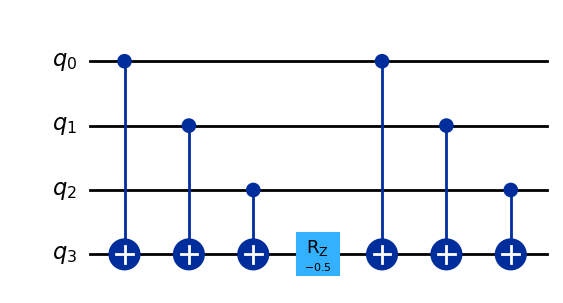

from which we can get the $U_{fh}$ as:

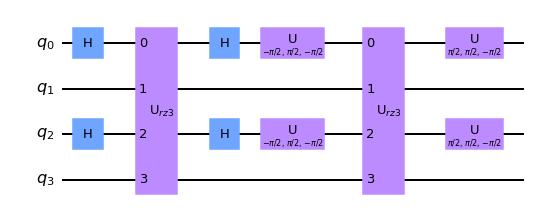

Notice that this gate requires 12 $CNOTs$.  Since 2-qubit gates errors are much larger than 1 qubit errors, the errors in $U_{fh}$ dominate our circuit.

We will come back to this.


## ...Ready for it?

So first of, lets of course set up all the imports that we need:

* numpy
* import everything from qiskit
* import `matplotlib.pyplot` as plt
* Make sure you have $\pi$
* from scipy.optimize import curve_fit

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
# Importing standard Qiskit libraries
from qiskit import *

# importing Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService

# import basic plot tools
from qiskit.visualization import plot_histogram

from math import pi
import matplotlib.pyplot as plt

Next, you neeed to load your IBMQ account, and set your token

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

token=''
QiskitRuntimeService.delete_account()
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService()

service.least_busy(simulator=False)

<IBMBackend('ibm_brisbane')>

Copy over from yesterday your initalization of `N,epsilon`, and `mass`

## Gauge Kinetic Gate
Copy over your function for $RX(-\epsilon/2)$

## Fermion mass gate

Copy over your function for $RZ((-1)^{j+1}m\epsilon ) $

## Fermion hopping term

Copy over your functions for $RZ3$ and $U_{fh}$

As I highlighted for you before, this gate takes 12 CNOTs and 4 qubits even though we only need 3 qubits for our model.  This particular implementation of $U_{fh}$ that you have constructed is in fact not the smartest way one could implement this gate -- but it was the first one that I found years ago and used for a long time.  

Later, smarter people (like Erik perhaps) pointed out that you can do away with the ancilla qubit.  One possible 3 qubit implementation is given in the next cell

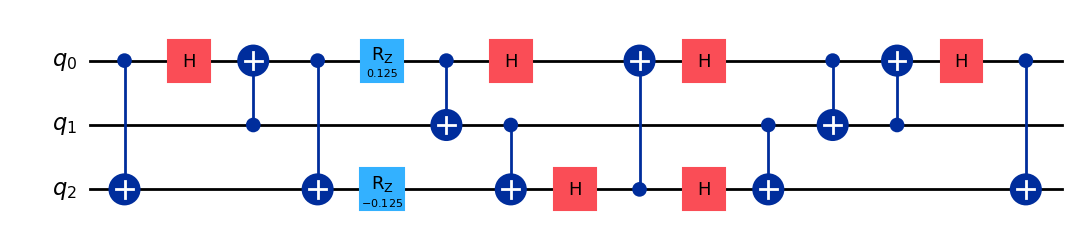

In [ ]:
qreg_q = QuantumRegister(3, 'q')

circuit = QuantumCircuit(qreg_q)

circuit.cx(qreg_q[0], qreg_q[2])
circuit.h(qreg_q[0])
circuit.cx(qreg_q[1], qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.rz(0.125, qreg_q[0])
circuit.rz(-0.125, qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.h(qreg_q[0])
circuit.h(qreg_q[2])
circuit.cx(qreg_q[2], qreg_q[0])
circuit.h(qreg_q[2])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.h(qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[0])
circuit.h(qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[2])

circuit.draw('mpl')

Unfortunately for you, I also designed this circuit.  As I would discover when

---

someone with a smirk passed me the paper <font color = 'blue'>https://arxiv.org/abs/1110.2998v1</font>, this can be further simplifed.  Any good quantum algorithms person will at one point or another in their life implement the quickest circuit they can come up with, and then later optimize.  Rememeber

**Premature optimization is the root of all evil **

Trying to get best circuit the first time is a great way to introduce bugs.  That said, looking through the diagrams in that paper, can you find places to reduce the gate count of this circuit and implement something better than my 2nd attempt -- Look at Figures of that paper starting at Fig 14?

Once you sort it out, write some code in the next cell for a function `def fermion_hopping_opt2` that implements the better circuit.  Once you are happy, flag an instructor to come see if you have sufficiently reduced it.

Better check you have properly implemented this with a decompose and a draw()

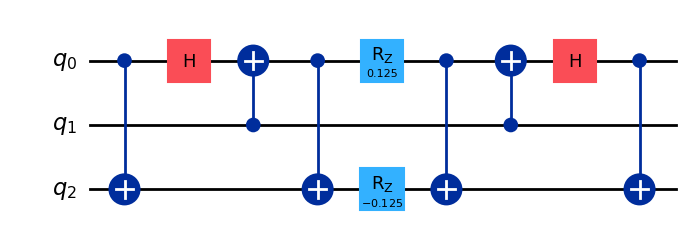

Now, clearly 3 qubits and 6 CNOTs is better than 4 qubits and 12 -- So we have done a much better job with our circuit.  With this improvement, we might just get some results from a real device!  Time to start putting the whole simulation together.

In order to extract physics from this simulation, we need to take the qubits and convert them into a meaningful number.  For this lab, we are going to extract the mean electron number as a function of time.  To do this, define a function `get_mean_fermion_number(counts)` which takes in the dictionary of counts of a run and determines the mean number of electrons by counting the lowest qubit.  

In [ ]:
#define your function to take in a dictionary counts
def get_mean_fermion_number(counts):
    #first define a variable mean and set to 0
    mean = 0
    #define a variable total_counts = sum(counts.values())
    total_counts = sum(counts.values())
    #perform a for loop over the elements in counts, using for example `s` as the loop variable
    for s in counts:
        #define a variable p which is the last element of the identifier in your loop variable
        #i.e. p = s[-1]
        p = s[-1]
        #check if p is a `1`.
        if p == '1':
            #if p == '1', then add to mean counts[s]/total_counts
            mean += 1./total_counts * counts[s]
    return mean

In order to understand how badly we are doing with our real device results, we need to be computing some kind of statistical error bars, so that we can distinguish meaningful disagreement with the exact results from fluctuations from sampling.  To do this, we will employ the _bootstrap method_ which is similar to the replica method that you were introduced to long ago during the Monte Carlo lab.  Lets implement that next:

In [ ]:
#define a function `get_bootstrap_error(counts)` which takes in a dictionary `counts`
def get_bootstrap_error(counts):
    #compute the nshots by using sum(counts.values())
    nshots=sum(counts.values())
    #For our statistics, we will resample the distribution 100 times, so set B=100
    B = 100
    #Extract the list of unique keys in your dictionary and store them as a variable k via
    # k = list(counts.keys())
    k = list(counts.keys())
    #For each key, we need to define a probability list prob via [counts[a]/nshots for a in k]
    prob = [counts[a]/nshots for a in k]
    #define an empty array means
    means = []
    #With all this setup, now perform a for loop over b in range(B)
    for b in range(B):
        #set a variable m=0
        m = 0
        #build a new set of samples using numpy.random.choice with the arguments k, size=nshots, and p=prob
        #this function will return nshots worth of new results with probability prob from the choices in k
        samples = np.random.choice(k, size=nshots, p=prob)
        #make a for loop over s in the list samples
        for s in samples:
            #set a new variable p = s[-1] to again extract the number of electrons
            p = s[-1]
            #check if p = `1`
            if p == '1':
                #add 1/nshots to m if true
                m += 1./nshots
        #append the results of m to means
        means.append(m)
    #return from the function the standard deviation of means via numpy.std(means)
    return np.std(means)

At this point, we have made all of the functions we need to run the code, and produce a time-evolution simulation.  So on to the main event:

* Define a bunch of empty list: `Ts`, and `circuits`
* Besides the above code, everything else should be within a for-loop in `T` over the `range(int(1.5/epsilon))` which will loop over the total integer time `T`.  The real total time is $\epsilon T$
* At the beginning of each step, append `T` to `Ts`
* Create a QuantumCircuit with enough qubits and classical bits to run using `fermion_hopping_opt2`.  Remember the number of fermions is stored as $N$.
* In order to do time-evolution of a state $|\psi(t)\rangle$, we need to define the initial state.  For us, lets use $H_0X_0|000\rangle$ as our initial state. The subscripts indicate which qubit the gates act on.
* Within the $T$ loop, we need another loop over $t$ which ranges from 0 to $T$.  This will be used to add the appropriate number of gates for the number of trotter steps $t$ taken.

Within the $t$ loop, you will need 3 loops:
 1. Loop over all fermions (Hint, this is not a simple range function but should step by 2). Appending to your circuit the fermion mass gate with parameters `epsilon`, `mass`, and for eta one should send in $(-1)^{n/2+1}$ where $n$ is the loop variable.
 2. Loop over all the photons (Hint, this is not a simple range function but should step by 2).  Append to your circuit `gauge_kinetic` with `epsilon`
 3. Loop over all electrons (Hint this loop should have the same step as the fermion loop, but should terminate 2 qubits earlier

At the end, still inside the $T$ loop but outside the $t$ loop,
* apply the gates to your qubits: $H_0H_2|\psi\rangle$
* append the circuit you created to the list `circuits`

 This completes time evolution and circuit creation. Draw some of your circuits to check they look like what you are expecting.

┌───┐    ┌───┐┌───────┐┌─────────────┐ ┌───────┐  ┌─────────────┐┌───┐»
q_0: ───┤ X ├────┤ H ├┤ U$_m$ ├┤0            ├─┤ U$_m$ ├──┤0            ├┤ H ├»
     ┌──┴───┴───┐└───┘└───────┘│             │┌┴───────┴─┐│             │└───┘»
q_1: ┤ U$_{Kg}$ ├──────────────┤1 U$_{fho2}$ ├┤ U$_{Kg}$ ├┤1 U$_{fho2}$ ├─────»
     └┬───────┬─┘              │             │└┬───────┬─┘│             │┌───┐»
q_2: ─┤ U$_m$ ├────────────────┤2            ├─┤ U$_m$ ├──┤2            ├┤ H ├»
      └───────┘                └─────────────┘ └───────┘  └─────────────┘└───┘»
c: 3/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«        ┌─┐   
«q_0: ───┤M├───
«     ┌─┐└╥┘   
«q_1: ┤M├─╫────
«     └╥┘ ║ ┌─┐
«q_2: ─╫──╫─┤M├
«      ║  ║ └╥┘
«c: 3/═╩══╩══╩═
«      1  0  2

First define some more empty arrays `sim_counts`, `sim_means`, `sim_errs`

You should set up a AerSimulator, transpile `circuits`, and run. Then read the code and check that it creates for loop that:

* extracts the counts for each of the times ran for
* computes the mean of the counts for each time
* computes the statistical error for each count each time
* prints `T*epsilon, sim_means[T], sim_errs[T]` at each time step to get the numbers instantly.

0.0 0.5166015625 0.01343643184231127
0.5 0.427734375 0.015637479757391912
1.0 0.357421875 0.01617906788257062


At this point, contact a lab instructor to come check your code, because the last step is to extend the time step from $1/\epsilon$ to $3/\epsilon$ (By changing the range to `int(3.5/epsilon)`.  Copy your code from before to the cell below, and make this modification. This will require many more calls to the real device, so it could take a while.  Then run the simulation cell further below

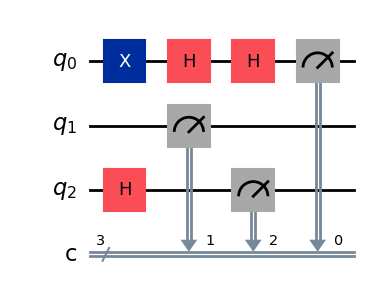

In [ ]:
sim_backend = AerSimulator()
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=3)
transpiled_circuit = pm.run(circuits)
sampler = Sampler(backend=sim_backend)
sim_job=sampler.run(transpiled_circuit)


backend = service.least_busy(simulator=False)
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
transpiled_circuit = pm.run(circuits)

#Set up the Sampler with backend
sampler = Sampler(backend=backend)

#Run the circuits, and get results
#job = sampler.run(transpiled_circuit)

#print(f">>> Job ID: {job.job_id()}")
#print(f">>> Job Status: {job.status()}")

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=3>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=3>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=3>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=3>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=3>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=3>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=3>)))], metadata={})


<ipython-input-40-0cfa9fd00cd3>:8: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=sim_backend)


Get your job back, and store it in `result`

In [ ]:
job_id=''
job = service.job(job_id)
sim_result=sim_job.result()
result=job.result()

In [ ]:
counts=[]
sim_counts=[]
means=[]
errs=[]
sim_means=[]
sim_errs=[]

for T in range(int(3.5/epsilon)):

  sim_counts.append(sim_result[T].data.c.get_counts())
  sim_means.append(get_mean_fermion_number(sim_counts[T]))
  sim_errs.append(get_bootstrap_error(sim_counts[T]))

  counts.append(result[T].data.c.get_counts())
  means.append(get_mean_fermion_number(counts[T]))
  errs.append(get_bootstrap_error(counts[T]))

  print(T*epsilon, sim_means[T], sim_errs[T], means[T], errs[T])

0.0 1.0 0.0 0.992431640625 0.001104905594983152
0.5 0.9375 0.006709339737677335 0.83154296875 0.00628135967633351
1.0 0.7451171875 0.015466961998147807 0.612548828125 0.007764302929836465
1.5 0.498046875 0.014003575958230093 0.409912109375 0.007724272941275022
2.0 0.2861328125 0.014464984049414112 0.273193359375 0.006608176896102472
2.5 0.0927734375 0.009210366785489175 0.237548828125 0.0065963543995946165
3.0 0.009765625 0.002806984473543948 0.26806640625 0.00719189385165423


After your done, run the next cell.  It should plot the simulator results (blue) vs the real device (red).  How did you do?  Do they agre e within errors everywhere?  Do they start getting worse?

<ErrorbarContainer object of 3 artists>

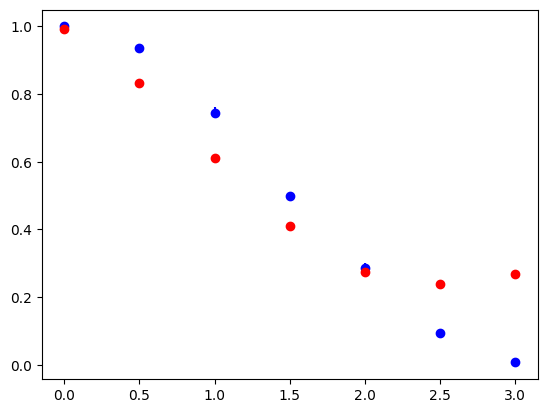

In [ ]:
plt.errorbar(Ts, sim_means , yerr=sim_errs, ls='', marker='o', color='b')
plt.errorbar(Ts, means , yerr=errs, ls='', marker='o', color='r')

For those of us in High Energy Physics, there is something interesting in this plot.  We earlier discussed that a state will oscillate like $e^{-i E t}|\psi_0\rangle$.  If you take the right combination of observables, you would get a sin(Et) or cos(Et).  In this case, measuring the frequency of the wave tells you the energy of the state you have prepared.  Can you extract a fit to your data and derive a value of the energy?

A good reference for how one might implement such a function is https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html, although you need to import scipy to make it work.  The functional form you will want to fit is $A*sin(B*t+C)+D$, and the resulting $B$ would be an estimate of the energy.

Printed at the bottom are the exact value when $\epsilon$ goes to zero, your simulated result, and the real device.

In [ ]:
def func(x, a,b,c,d):
    return a * np.sin(b * x + c) +d

popt, pcov = curve_fit(func, Ts, sim_means)
rpopt, rpcov = curve_fit(func, Ts, means)
print("Exact: ",1.03)
print(" Simulated: ",popt[1])
print("Real Device: ",rpopt[1])

Exact:  1.03
 Simulated:  0.9876900107727801
Real Device:  0.9665869301967304


This cell plots your simulated (blue) and real (red) results with their best fits along side the exact result (green).

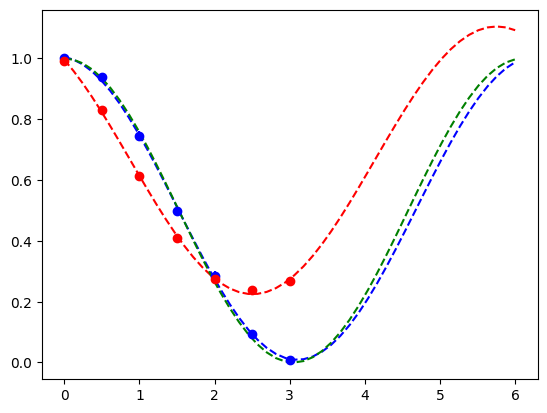

In [ ]:
plt.errorbar(Ts, sim_means , yerr=sim_errs, ls='', marker='o', color='b')
plt.errorbar(Ts, means , yerr=errs, ls='', marker='o', color='r')
plt.plot(np.linspace(0,6,50), func(np.array(np.linspace(0,6,50)), *popt), 'b--')
plt.plot(np.linspace(0,6,50), func(np.array(np.linspace(0,6,50)), *rpopt), 'r--')
plt.plot(np.linspace(0,6,50), func(np.array(np.linspace(0,6,50)), *[0.5,1.03,np.pi/2,0.5]), 'g--')